In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import seaborn as sns
import os

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
# ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.chdir("drive/MyDrive/kalbe dataset")

# Load data and data cleansing

In [5]:
product = pd.read_csv('Product.csv', sep=';')
customer = pd.read_csv('Customer.csv', sep=';')
transaction = pd.read_csv('Transaction.csv', sep=';')
store = pd.read_csv('Store.csv', sep=';')

### product

In [6]:
product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [7]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [8]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

### customer

In [9]:
customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [10]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [11]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [12]:
customer["Gender"] = customer['Gender'].astype('object')

In [13]:
customer['Income'] = customer['Income'].replace(',','.',regex=True)

In [14]:
customer["Income"] = customer['Income'].astype(float)

In [15]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 17.6+ KB


In [16]:
# fill missing value with the most frequent value of that column
customer['Marital Status']=customer['Marital Status'].fillna(customer['Marital Status'].mode()[0])

In [17]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

### transaction

In [18]:
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [19]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [20]:
transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [21]:
transaction['Date']=pd.to_datetime(transaction['Date'])

### store

In [22]:
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [23]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [24]:
store.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

# Merging all data

In [25]:
df_merged = pd.merge(transaction, product, on='ProductID', how='left')
df_merged = pd.merge(df_merged, store, on='StoreID', how='left')
df_merged = pd.merge(df_merged, customer, on='CustomerID', how='left')

# Data preparation

In [26]:
df = df_merged.groupby('Date').agg({'Qty':'sum'})

In [27]:
df

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


<Axes: xlabel='Date'>

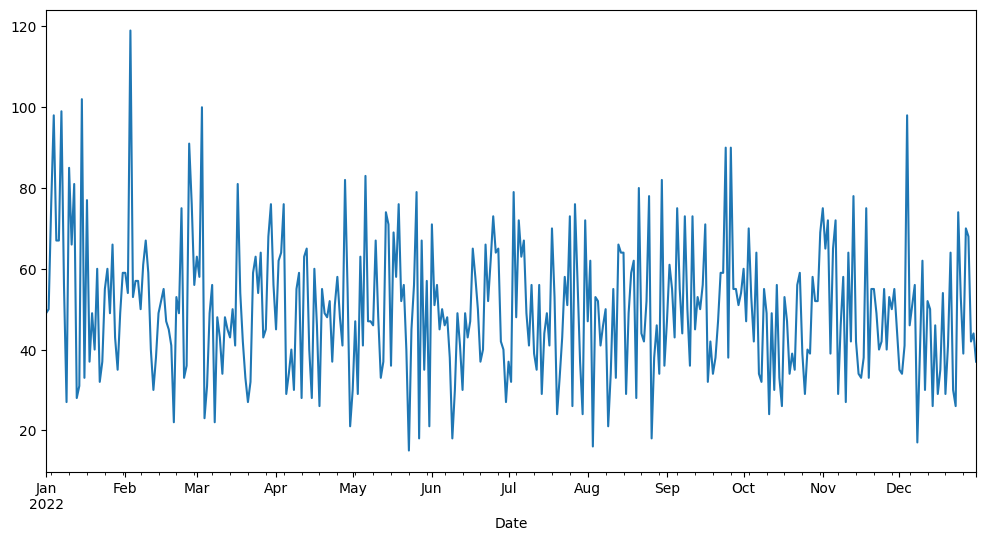

In [28]:
df['Qty'].plot(figsize=(12,6))

## Check Stationarity

In [29]:
X = df['Qty'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


p-value <= 0.05: the data does not have a unit root and **is stationary**.

# Modelling

Figure out order for ARIMA model

In [30]:
auto_arima_model = pm.auto_arima(df['Qty'],
                                 seasonal=False,
                                 stepwise=False,
                                 trace=True,
                                 suppress_warnings=True)
auto_arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3933.778, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3688.453, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3567.999, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3492.571, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=3418.983, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3390.160, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3330.761, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3103.284, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3105.214, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3108.195, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=3107.018, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3232.248, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3105.211, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3106.213, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3108.211, Time=0.55 sec
 ARIMA(3,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1548.642
Date:                Mon, 06 Nov 2023   AIC                           3103.284
Time:                        16:06:47   BIC                           3114.984
Sample:                    01-01-2022   HQIC                          3107.934
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   4.52e-05   2.21e+04      0.000       1.000       1.000
ma.L1         -0.9827      0.014    -72.182      0.000      -1.009      -0.956
sigma2       279.3379     20.612     13.552      0.000     238.939     319.736
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                10.35
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                             0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split dataset

In [31]:
train_size = int(len(df['Qty']) * 0.8)
train_data = df['Qty'][:train_size]
test_data = df['Qty'][train_size:]
print(train_data.shape,test_data.shape)

(292,) (73,)


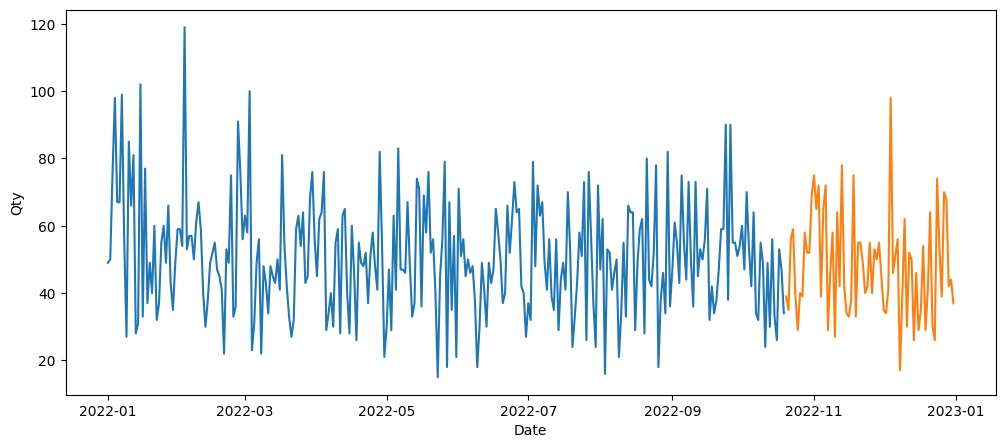

In [32]:
# visualize
plt.figure(figsize=(12,5))
sns.lineplot(data=train_data, x=train_data.index, y=train_data)
sns.lineplot(data=test_data, x=test_data.index, y=test_data)
plt.show()

## Train the model

In [33]:
model = ARIMA(train_data, order=(1,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1240.473
Date:                Mon, 06 Nov 2023   AIC                           2488.946
Time:                        16:06:48   BIC                           2503.653
Sample:                    01-01-2022   HQIC                          2494.837
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6358      1.055     48.009      0.000      48.569      52.703
ar.L1         -0.9861      0.036    -27.118      0.000      -1.057      -0.915
ma.L1          0.9754      0.049     19.707      0.000       0.878       1.072
sigma2       286.6478     21.811     13.142      0.000     243.899     329.397
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                23.73
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.59
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict on test set

In [34]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred = model.predict(start=start,end=end,typ='levels')
print(pred)

2022-10-20    51.424681
2022-10-21    49.857847
2022-10-22    51.402870
2022-10-23    49.879355
2022-10-24    51.381662
                ...    
2022-12-27    50.939891
2022-12-28    50.335889
2022-12-29    50.931483
2022-12-30    50.344180
2022-12-31    50.923307
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


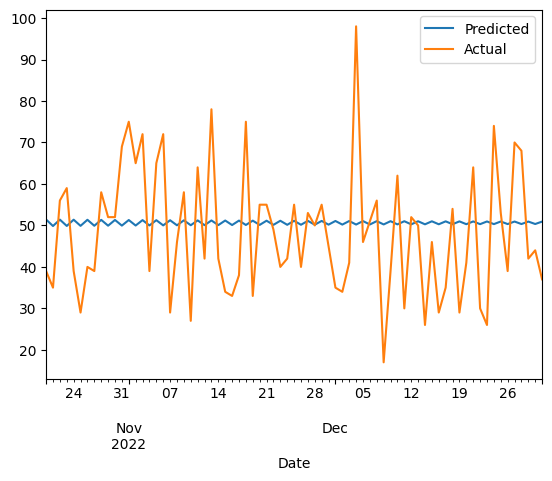

In [35]:
pred.plot(label='Predicted')
test_data.plot(label='Actual')

plt.legend()
plt.show()

In [36]:
rmse = sqrt(mean_squared_error(test_data,pred))
print(rmse)

15.49482859020857


# Improvement: Manual ARIMA

In [37]:
model = ARIMA(train_data, order=(70,2,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  292
Model:                ARIMA(70, 2, 2)   Log Likelihood               -1204.991
Date:                Mon, 06 Nov 2023   AIC                           2555.981
Time:                        16:10:26   BIC                           2823.883
Sample:                    01-01-2022   HQIC                          2663.316
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3367      0.771     -1.734      0.083      -2.847       0.174
ar.L2         -1.2783      0.819     -1.561      0.119      -2.883       0.327
ar.L3         -1.2079      0.810     -1.491      0.136      -2.796       0.380
ar.L4         -1.1604      0.810     -1.432      0.152      -2.749       0.428
ar.L5         -1.2376      0.820     -1.509      0.131      -2.845       0.369
ar.L6         -1.2646      0.920     -1.375      0.169      -3.067       0.538
ar.L7         -1.2880      0.970     -1.328      0.184      -3.189       0.613
ar.L8         -1.3245      1.037     -1.277      0.202      -3.357       0.708
ar.L9         -1.3445      1.100     -1.222      0.222      -3.501       0.812
ar.L10        -1.3963      1.160     -1.204      0.229      -3.670       0.877
ar.L11        -1.4451      1.248     -1.158      0.247      -3.892       1.002
ar.L12        -1.4602      1.331     -1.097      0.273      -4.068       1.148
ar.L13        -1.4888      1.391     -1.070      0.285      -4.216       1.238
ar.L14        -1.5774      1.470     -1.073      0.283      -4.458       1.303
ar.L15        -1.6362      1.578     -1.037      0.300      -4.729       1.457
ar.L16        -1.7058      1.644     -1.038      0.299      -4.927       1.516
ar.L17        -1.6573      1.728     -0.959      0.337      -5.044       1.729
ar.L18        -1.6760      1.732     -0.968      0.333      -5.071       1.719
ar.L19        -1.7631      1.796     -0.982      0.326      -5.283       1.757
ar.L20        -1.7337      1.884     -0.920      0.357      -5.426       1.958
ar.L21        -1.6702      1.909     -0.875      0.382      -5.412       2.072
ar.L22        -1.6472      1.931     -0.853      0.394      -5.432       2.137
ar.L23        -1.5939      1.950     -0.818      0.414      -5.415       2.227
ar.L24        -1.4993      1.953     -0.768      0.443      -5.327       2.329
ar.L25        -1.5024      1.939     -0.775      0.438      -5.303       2.298
ar.L26        -1.5661      1.954     -0.801      0.423      -5.396       2.264
ar.L27        -1.5757      1.994     -0.790      0.429      -5.485       2.333
ar.L28        -1.4029      2.003     -0.700      0.484      -5.329       2.523
ar.L29        -1.3502      1.951     -0.692      0.489      -5.174       2.473
ar.L30        -1.3443      1.958     -0.687      0.492      -5.181       2.493
ar.L31        -1.2772      1.952     -0.654      0.513      -5.102       2.548
ar.L32        -1.2411      1.928     -0.644      0.520      -5.020       2.537
ar.L33        -1.3391      1.918     -0.698      0.485      -5.098       2.419
ar.L34        -1.3214      1.961     -0.674      0.500      -5.164       2.522
ar.L35        -1.2907      1.934     -0.667      0.505      -5.082       2.501
ar.L36        -1.2022      1.917     -0.627      0.530      -4.959       2.554
ar.L37        -1.0959      1.868     -0.587      0.558      -4.758       2.566
ar.L38        -1.1273      1.816     -0.621      0.535      -4.687       2.432
ar

In [38]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred = model.predict(start=start,end=end,typ='levels')
print(pred)

2022-10-20    55.678644
2022-10-21    64.094220
2022-10-22    61.613730
2022-10-23    46.876361
2022-10-24    61.515625
                ...    
2022-12-27    55.031881
2022-12-28    45.229891
2022-12-29    49.573953
2022-12-30    49.266989
2022-12-31    45.342359
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


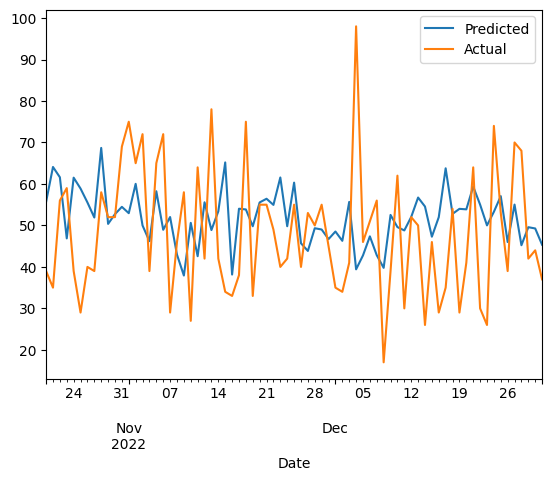

In [40]:
pred.plot(label='Predicted')
test_data.plot(label='Actual')

plt.legend()
plt.show()

In [39]:
rmse = sqrt(mean_squared_error(test_data,pred))
print(rmse)

17.333560693932814


# Forecast for all product

In [42]:
product_reg_df = df_merged[['Qty', 'Date', 'Product Name']]
new = product_reg_df.groupby("Product Name")

forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = ARIMA(target_var.values, order=(1,0,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(90)
    forecast_product_df[product_name] = forecast

forecast_product_df.set_index('Date', inplace=True)
forecast_product_df.head()

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-01,2.643780,2.887033,5.719084,3.922062,3.536212,4.854919,1.989118,2.807238,3.472691,4.060748
2023-01-02,2.400617,2.916508,5.841903,3.982036,3.498383,4.931029,1.989644,2.803930,3.521524,3.985260
2023-01-03,2.477836,2.935584,5.920862,4.004379,3.526270,4.949085,1.989686,2.802217,3.496307,4.059759
2023-01-04,2.453314,2.947930,5.971625,4.012703,3.505712,4.953368,1.989689,2.801329,3.509329,3.986237
2023-01-05,2.461101,2.955920,6.004260,4.015804,3.520867,4.954385,1.989690,2.800869,3.502604,4.058795


In [45]:
#Products Quantity forecast
round(forecast_product_df.describe().T['mean'],0)

Cashew           2.0
Cheese Stick     3.0
Choco Bar        6.0
Coffee Candy     4.0
Crackers         4.0
Ginger Candy     5.0
Oat              2.0
Potato Chip      3.0
Thai Tea         4.0
Yoghurt          4.0
Name: mean, dtype: float64

# Future Improvement

*   Rolling forecast
*   Other methods: Manual ARIMA, Exponential Smoothing (ES), Simple ES

